# Imbalanced Data

In [1]:
conda install -c conda-forge imbalanced-learn

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.model_selection import train_test_split 
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import ADASYN

In [3]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                           n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
data = pd.concat([pd.DataFrame(X),pd.DataFrame(y, columns =['y'])], axis =1)
data.head()

,0,1,y
0,0.222014,0.540207,0
1,1.347439,1.412824,0
2,0.537238,0.372730,0
3,2.134462,1.404819,0
4,2.315827,1.356858,0


In [4]:
def plot_data(data):
    for label in data['y'].unique():
        row = data[data['y'] == label]
        plt.scatter(row[0], row[1], label=str(label))
    plt.legend()
    plt.show()

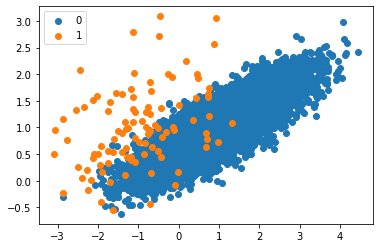

In [5]:
plot_data(data)

## Baseline Methods 

In [6]:
n0 = len(data[data['y']==0])
n1 = len(data[data['y']==1])
print(n0,n1)

9900 100


### Under-sampling
Removing samples from the majority class

0    100
1    100
Name: y, dtype: int64


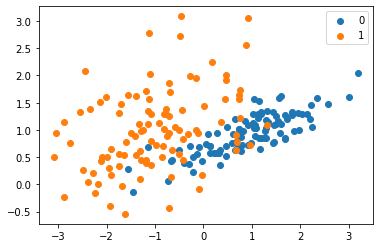

In [7]:
undersampled_data = pd.concat([data[data['y']==0].sample(n1, random_state=1), data[data['y']==1]])
print(undersampled_data['y'].value_counts())
plot_data(undersampled_data)

### Over-sampling
Adding more examples from the minority class.

0    9900
1    9900
Name: y, dtype: int64


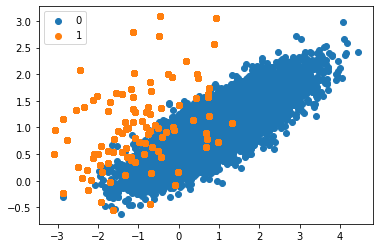

In [8]:
oversampled_data = pd.concat([data[data['y']==0], data[data['y']==1].sample(n0, replace=True, random_state=1)])
print(oversampled_data['y'].value_counts())
plot_data(oversampled_data)

Those methods can balance the class distribution but do not provide any additional information to the model.

## SMOTE
The most widely used approach to synthesizing new examples from the minority class. This is a type of data augmentation for tabular data and can be very effective.

In [10]:
smote_oversample = SMOTE(random_state = 1)
smote_X, smote_y = smote_oversample.fit_resample(X, y)

0    9900
1    9900
Name: y, dtype: int64


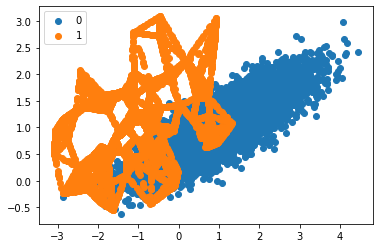

In [11]:
smote_data = pd.concat([pd.DataFrame(smote_X),pd.DataFrame(smote_y, columns =['y'])], axis =1)
print(smote_data['y'].value_counts())
plot_data(smote_data)

In [12]:
smote_oversample = SMOTE(random_state = 1, k_neighbors = 3)
smote_X, smote_y = smote_oversample.fit_resample(X, y)

0    9900
1    9900
Name: y, dtype: int64


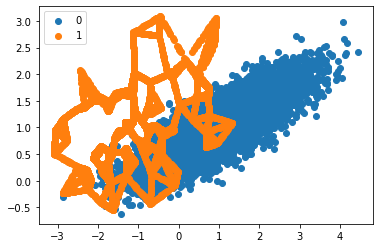

In [13]:
smote_data = pd.concat([pd.DataFrame(smote_X),pd.DataFrame(smote_y, columns =['y'])], axis =1)
print(smote_data['y'].value_counts())
plot_data(smote_data)

The original paper on SMOTE suggested combining SMOTE with random undersampling of the majority class.<br>
We can first oversample the minority class using SMOTE, then use random undersampling to reduce the number of examples in the majority class.

0    3960
1    1980
Name: y, dtype: int64


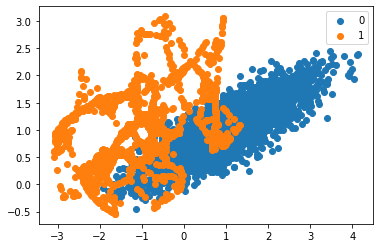

In [14]:
over = SMOTE(sampling_strategy=0.2, random_state = 1)
under = RandomUnderSampler(sampling_strategy=0.5, random_state = 1)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
smote2_X, smote2_y = pipeline.fit_resample(X, y)
smote2_data = pd.concat([pd.DataFrame(smote2_X),pd.DataFrame(smote2_y, columns =['y'])], axis =1)
print(smote2_data['y'].value_counts())
plot_data(smote2_data)

### SMOTE for Classification

First, let's generate a decision tree classifier on the original dataset.

In [15]:
clf = DecisionTreeClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))
# scores = cross_val_score(clf, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# print('Mean Accuracy: %.3f' % np.mean(scores))

Mean ROC AUC: 0.772


Now, let's use a SMOTE transformed version of the dataset.<br>
When using k-fold cross-validation, the oversampling should be applied on the training dataset only, then evaluate the model on the non-transformed test set.

In [16]:
steps = [('over', SMOTE()), ('model', DecisionTreeClassifier())]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.831


In [17]:
clf = DecisionTreeClassifier()
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('over', over), ('under', under), ('model', clf)]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.832


SMOTE use k-nearest neighbors to create the new synthetic examples. <br>
The default is k=5, although larger or smaller values will influence the types of examples created, and may impact the performance of the model.


In [18]:
mean_score = []
for k in range(1,11):
    model = DecisionTreeClassifier()
    over = SMOTE(sampling_strategy=0.1, k_neighbors=k) # TODO here
    under = RandomUnderSampler(sampling_strategy=0.5)
    steps = [('over', over), ('under', under), ('model', model)]
    pipeline = Pipeline(steps=steps)
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    score = np.mean(scores)
    mean_score.append(score)
    print('k=%d, Mean ROC AUC: %.3f' % (k, score))

k=1, Mean ROC AUC: 0.828
k=2, Mean ROC AUC: 0.824
k=3, Mean ROC AUC: 0.824
k=4, Mean ROC AUC: 0.828
k=5, Mean ROC AUC: 0.839
k=6, Mean ROC AUC: 0.848
k=7, Mean ROC AUC: 0.842
k=8, Mean ROC AUC: 0.841
k=9, Mean ROC AUC: 0.853
k=10, Mean ROC AUC: 0.852


Text(0, 0.5, 'mean score')

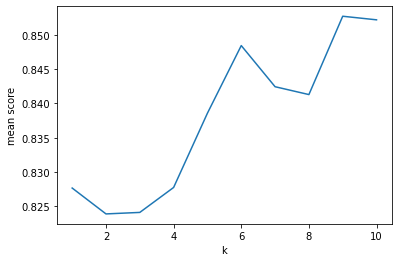

In [19]:
plt.plot(range(1,11), mean_score)
plt.xlabel('k')
plt.ylabel('mean score')

## Adaptive Synthetic Sampling (ADASYN)
Generating synthetic samples inversely proportional to the density of the examples in the minority class.

0    9900
1    9899
Name: y, dtype: int64


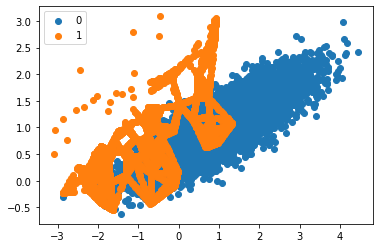

In [20]:
oversample = ADASYN(random_state = 1)
adasyn_X, adasyn_y = oversample.fit_resample(X, y)
adasyn_data = pd.concat([pd.DataFrame(adasyn_X),pd.DataFrame(adasyn_y, columns =['y'])], axis =1)
print(adasyn_data['y'].value_counts())
plot_data(adasyn_data)

0    9900
1    9892
Name: y, dtype: int64


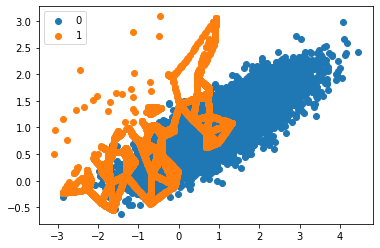

In [21]:
oversample = ADASYN(random_state = 1, n_neighbors = 3)
adasyn_X, adasyn_y = oversample.fit_resample(X, y)
adasyn_data = pd.concat([pd.DataFrame(adasyn_X),pd.DataFrame(adasyn_y, columns =['y'])], axis =1)
print(adasyn_data['y'].value_counts())
plot_data(adasyn_data)

In [22]:
clf = DecisionTreeClassifier()
oversample = ADASYN(random_state = 1)
steps = [('over', oversample),('model', clf)]
pipeline = Pipeline(steps=steps)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(scores))

Mean ROC AUC: 0.810
